In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, bisect, fsolve

In [128]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [129]:
class Libor:

    def __init__(self,
                 delta=0.90,       # discount factor
                 b = 0.1,          # parameter of the utility
                 S = 3,
                 x_grid_min=0, 
                 x_grid_max=1,  # maximum value of the initial subjective proba
                 x_grid_size=100):

        self.delta = delta
        self.b = b
        self.S = S
        self.x_grid_size = x_grid_size

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, y, x):

        b = self.b
        S=self.S

        return b*y - (S*x*y*y)/2

    # first derivative of utility function
    def u_prime(self, y,x):

        return self.b-self.S*x*y

    def state_action_value(self, y, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        delta = self.delta
        u = self.u
        v = lambda x: np.interp(x,self.x_grid, v_array)

        return u(y,x) + delta*(1-y*x) * v(x*(1-y)/(1-x*y))

In [130]:
def T(v, Libor):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(Libor.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(Libor.state_action_value, 0, 1, (x, v))[1]

    return v_new

In [131]:
li = Libor()

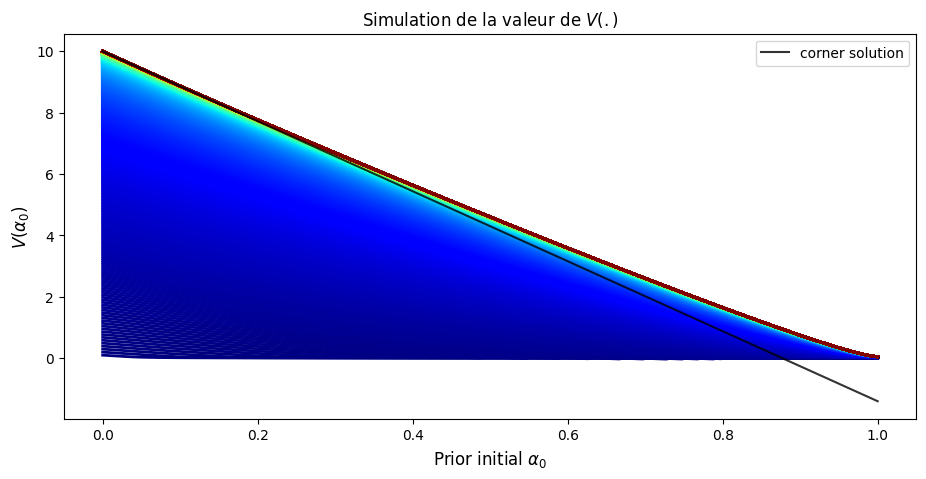

In [133]:
x_grid = li.x_grid
#v = li.u(x_grid,2) # Initial guess
v = np.empty(li.x_grid_size)*0
n = 1000 # Number of iterations

fig, ax = plt.subplots()

# ax.plot(x_grid, v, color=plt.cm.jet(0),
#       lw=2, alpha=0.8, label='Initial guess')

for i in range(n):
    v_last =v
    v = T(v, li)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=1)
    v_err=max(abs(v-v_last))

# case where the solution is corner (gamma=1)

#v_corn = li.b +li.delta*li.b/(1-li.delta)*(1-x_grid)
v_corn = li.b/(1-li.delta) -(li.S/2+li.delta*li.b/(1-li.delta))*x_grid
ax.plot(x_grid,v_corn, color='black',alpha=0.8, label='corner solution')

ax.legend()
ax.set_ylabel('$V(\\alpha_0)$', fontsize=12)
ax.set_xlabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_title('Simulation de la valeur de $V(.)$')

plt.show()

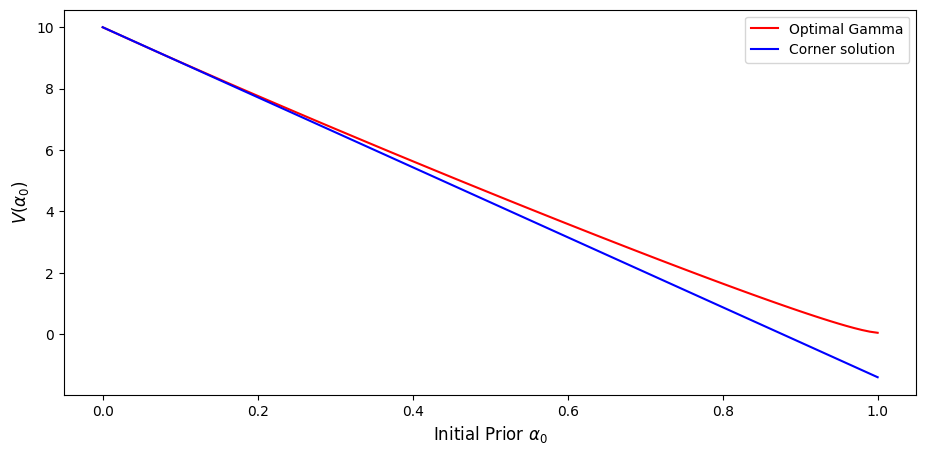

In [136]:
#modifs DM 
#v_func = lambda x : np.interp(x,x_grid,v)
v_func = interp1d(x_grid, v, kind='cubic',fill_value='extrapolate')

plt.figure()
plt.plot(x_grid, v_func(x_grid), label = "Optimal Gamma", color='red')  # Mettre en vert
plt.plot(x_grid,v_corn, label='Corner solution', color='blue')  # Mettre en bleu
#plt.title('Simulation of the value of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V(\\alpha_0)$", fontsize=12)

plt.legend()
plt.savefig('figure_3.png')
plt.show()

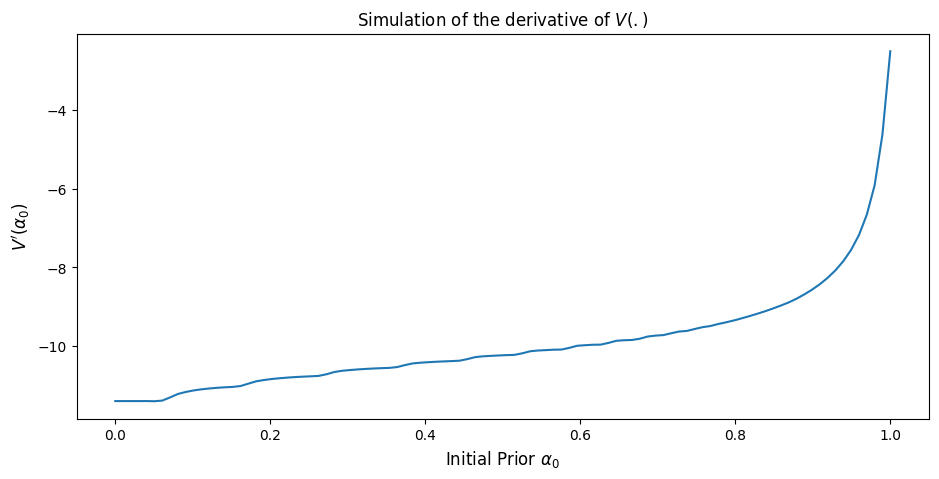

In [137]:
def dv_func(x, eps = 0.00001):
    return (v_func(x+eps)-v_func(x))/eps

plt.plot(x_grid, dv_func(x_grid))
plt.title('Simulation of the derivative of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V'(\\alpha_0)$", fontsize=12)
plt.show()

In [138]:
# threshold value of alpha
alpha_h = li.b/(li.S+li.delta*(li.b-0.5*li.S))
alpha_h

0.061957868649318466

In [139]:
n_gamma=1000
alpha_range = np.linspace(alpha_h,0.999,n_gamma)
#gamma_range = np.linspace(0.01,0.99, 1000)

gammas = []
y0=alpha_h
for alpha in alpha_range:
    func_CPO = lambda y : li.u_prime((alpha-y)/(alpha*(1-y)),alpha)-li.delta*alpha*v_func(y)-li.delta*alpha*(1-y)*dv_func(y)
    #p = alpha*(1-gamma_range)/(1-alpha*gamma_range)
    sol = fsolve(func_CPO, x0= y0,xtol=1e-7)
    #gamma_approx_index = np.argmin(np.abs(res))
    #gamma_approx = gamma_range[gamma_approx_index]
    gammas.append((alpha-sol[0])/(alpha*(1-sol[0])))
    y0=alpha

In [140]:
gammas[n_gamma-1]

0.017820359957626795

In [141]:
n_corner=50
alpha_init = np.linspace(0.001,alpha_h-0.002,n_corner)
alphavec=np.concatenate([alpha_init,alpha_range])

n_tot = n_corner+n_gamma

gammavec_6 = [1]*n_corner
gammavec_6 = gammavec_6+gammas

In [142]:
#policy function cas à 1 période
gamma_1per = li.b/(li.S*alphavec)

for i in range(n_tot):
    if gamma_1per[i]>1:
        gamma_1per[i]=1

In [143]:
gammavec_6[n_tot-1]

0.017820359957626795

In [144]:
gamma_theorique_1 = (np.sqrt((1-li.delta)**2*li.S**2+2*li.b*li.delta*(1-li.delta)*li.S)-(1-li.delta)*li.S)/(li.delta*li.S)
gamma_theorique_1

0.017745553034525706

In [145]:
sol[0]

0.9989818747855544

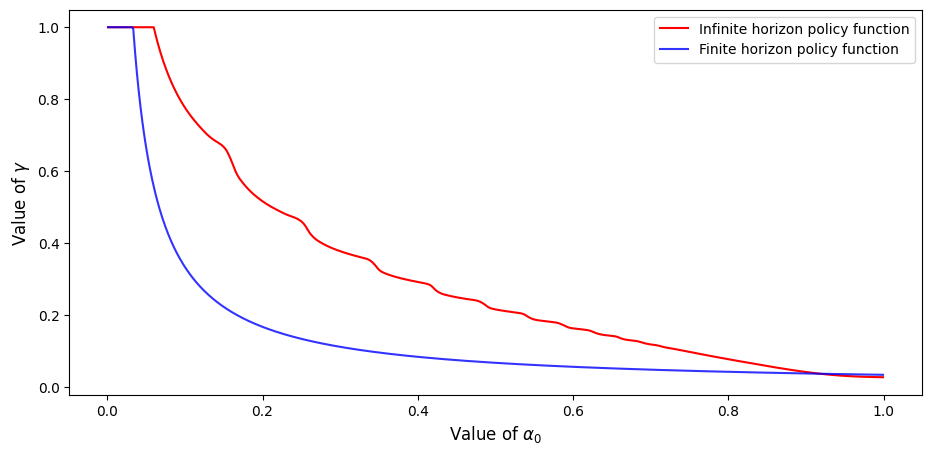

In [205]:

fig, ax = plt.subplots()
#ax.plot(alphavec,gammavec_1,color=plt.cm.jet(0), label='policy function, cubic, eps = 1e-4')
#ax.plot(alphavec,gammavec_2,color=plt.cm.jet(0.2), label='policy function, quadratic, eps = 1e-4')
#ax.plot(alphavec,gammavec_3,color=plt.cm.jet(0.4), label='policy function, linear, eps = 1e-4')
#ax.plot(alphavec,gammavec_4,color=plt.cm.jet(0.5), label='policy function, cubic, eps = 1e-5')
#ax.plot(alphavec,gammavec_5,color=plt.cm.jet(0.7), label='policy function, quadratic, eps = 1e-5')
# Remplacez les lignes de tracé par les nouvelles
ax.plot(alphavec,gammavec_6,color='red', label='Infinite horizon policy function')  # Mettre en vert
ax.plot(alphavec,gamma_1per, color='blue', alpha=0.8, label='Finite horizon policy function')  # Mettre en bleu

ax.legend()
ax.set_xlabel('Value of $\\alpha_0$', fontsize=12)
ax.set_ylabel('Value of $\\gamma$', fontsize=12)
#ax.set_title('Comparison of Optimal Interior $\\gamma$ (policy function) for Different $\\alpha_0$ Values')
plt.savefig('figure_6.png')
plt.show()

In [148]:
alphavec_new = np.array([0]+list(alphavec)+[1])
gammavec_6_new = np.array([1]+list(gammavec_6)+[gamma_theorique_1])
policy = interp1d(alphavec_new,gammavec_6_new)
policy(1)

array(0.01774555)

In [149]:
alphavec_new[1000]

0.9521009944268928

In [150]:
#gammavec_6_new[2051]

In [151]:
policy(1)

array(0.01774555)

In [152]:
x=0.7
policy(x)*x

0.11465024020937709

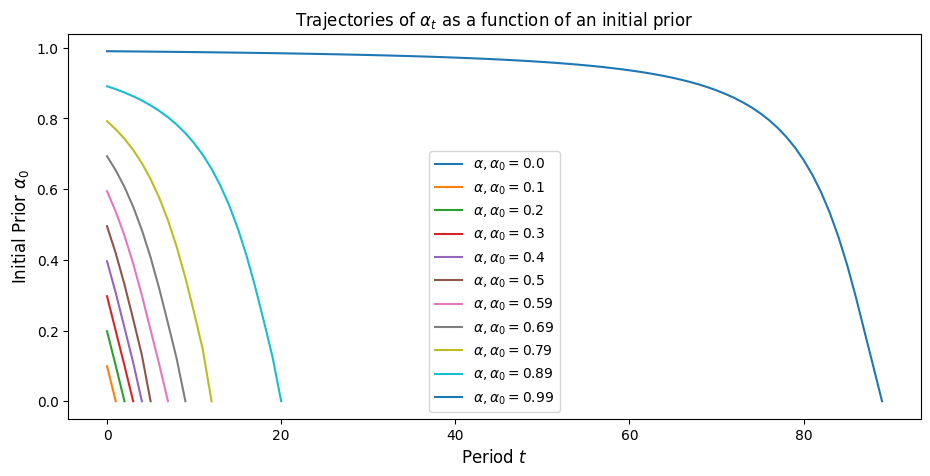

In [199]:
# simul inf pol modifs DM
Tmax = 1000
def simulation_inf_pol(alpha):
#, end=True):
    #done = False
    cum_reward = 0
    list_rewards = []
    list_alphas = []
    list_gammas = []

    t = 0
    while (alpha>alpha_h) and (t<Tmax):
        gamma = policy(alpha)
        # print(f"t= {t}, alpha = {alpha}, gamma = {gamma}")

        #u = np.random.uniform()  if end else 2
        #if u < gamma*alpha:
        #   done = True
        #else:
        cum_reward += li.b*gamma
        list_rewards.append(cum_reward)
        list_alphas.append(alpha)
        list_gammas.append(gamma)
        
        alpha = alpha * (1-gamma)/(1-alpha*gamma)
        t += 1
    list_rewards = np.array(list_rewards)
    list_alphas = np.array(list_alphas+[0])
    list_gammas = np.array(list_gammas+[1])
    return list_rewards, list_alphas, list_gammas


plt.figure()

for alpha0 in np.linspace(0, 0.99, 11):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0) 
    # end=False)
    plt.plot(alphas, label=f"$\\alpha, \\alpha_0 = {round(alpha0,2)}$")
    plt.title('Trajectories of $\\alpha_t$ as a function of an initial prior')
    plt.xlabel("Period $t$", fontsize=12)
    plt.ylabel("Initial Prior $\\alpha_0$", fontsize=12)

plt.legend()
plt.show()

average_has_stopped = []
horizon = 100
for alpha0 in np.linspace(0, 1, 30):
    has_stopped = []
    for _ in range(100):
        rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
        has_stopped.append(len(rws) < horizon)
    
    average_has_stopped.append(np.mean(np.array(has_stopped)))




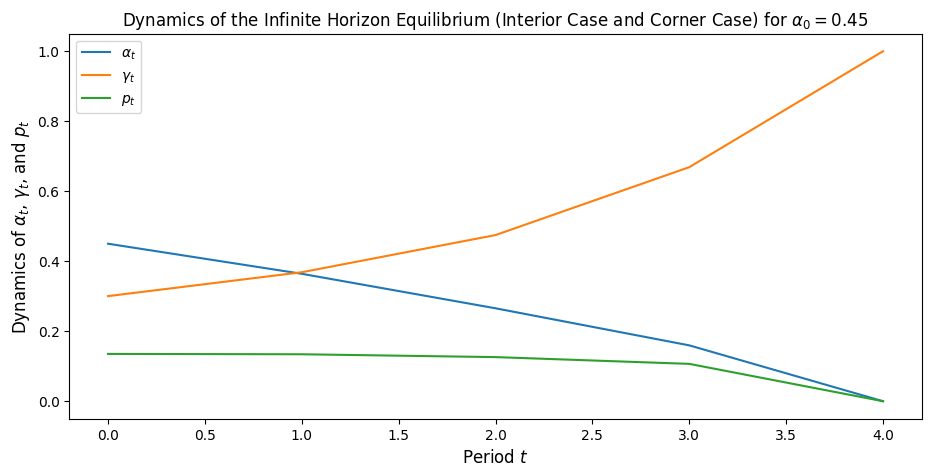

In [200]:
plt.figure()

alpha0 = 0.45
rws, alphas, gammas = simulation_inf_pol(alpha=alpha0) 
plt.plot(alphas, label=f"$\\alpha_t$")
plt.plot(gammas, label=f"$\\gamma_t$")
plt.plot(alphas*gammas, label=f"$p_t $")
plt.title('Dynamics of the Infinite Horizon Equilibrium (Interior Case and Corner Case) for $\\alpha_0 = 0.45$')
plt.xlabel("Period $t$", fontsize=12)
plt.ylabel("Dynamics of $\\alpha_t$, $\\gamma_t$, and $p_t$", fontsize=12)



plt.legend()
plt.show()

In [201]:
# Simulation one shot modifs DM

def simulation_one_shot(alpha, T=100):#,end = True):
    #done = False  #
    cum_reward = 0
    list_rewards = []
    list_alphas = []
    list_gammas = []

    t = 0
    while (alpha>li.b/li.S) and (t<Tmax):
        if alpha>0:
            gamma =min(1,li.b/(li.S*alpha))
        else:
            gamma=1
            
        cum_reward += li.b*gamma
        list_rewards.append(cum_reward)
        list_alphas.append(alpha)
        list_gammas.append(gamma)
        alpha = alpha * (1-gamma)/(1-alpha*gamma)

        t += 1
    list_rewards = np.array(list_rewards)
    list_alphas = np.array(list_alphas+[0])
    list_gammas = np.array(list_gammas+[1])
    return list_rewards, list_alphas, list_gammas

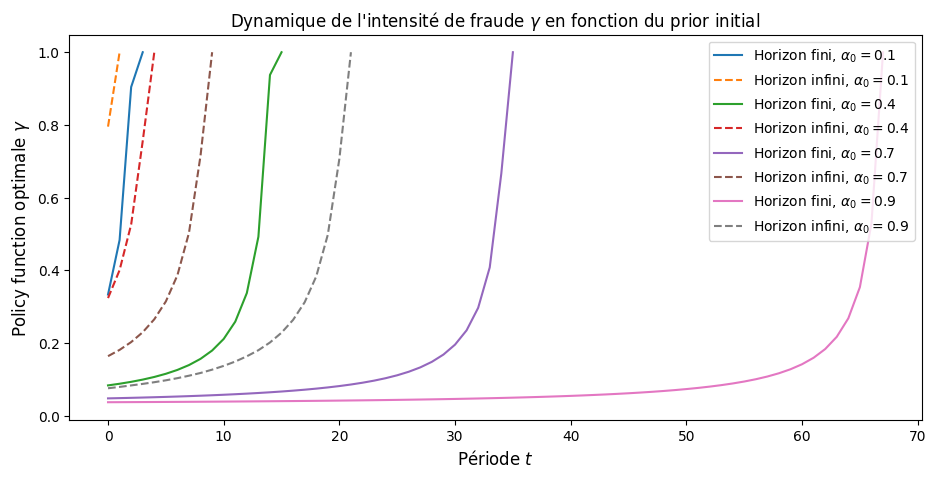

In [202]:
### plot gammas vs alphas Modifs DM
## dynamique d'accroissement de l'intensité de fraude
fig, ax = plt.subplots()

for alpha0 in [0.1,0.4,0.7,0.9]:
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0) #, end=False)
    plt.plot(gammas, label=f"Horizon fini, $\\alpha_0 = {alpha0}$")
    #print(f"alpha0 = {alpha0}, one shot, {social_cost_inactive(gammas)}")

    
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0) #, end=False)
    plt.plot(gammas, label=f"Horizon infini, $\\alpha_0 = {alpha0}$",linestyle = "--")
    #print(f"alpha0 = {alpha0}, inf shot, {social_cost_inactive(gammas)}")

    #plt.plot(gammas,label=f"$\gamma, \\alpha_0 = {alpha0}$")
    #plt.plot(gammas*alphas,label=f"$p, \\alpha_0 = {alpha0}$")

ax.legend()
ax.set_ylabel('Policy function optimale $\\gamma$', fontsize=12)
#ax.set_ylabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_xlabel('Période $t$', fontsize=12)
ax.set_title('Dynamique de l\'intensité de fraude $\\gamma$ en fonction du prior initial')

#plt.legend()
plt.show()

#pour le même alpha 0 avoir la même couleur entre le pointillé et la ligne continue



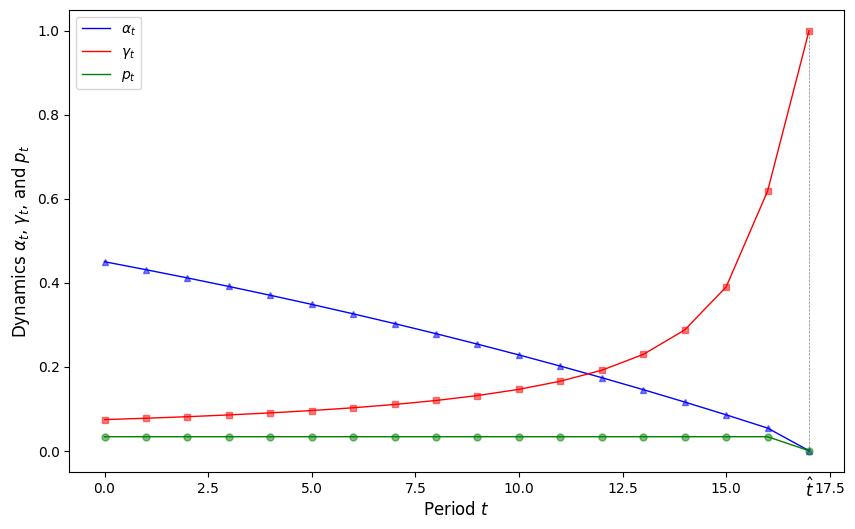

In [203]:
#########. Dynamics of the Finite Horizon Equilibrium (Interior Case and Corner Case) for $\\alpha_0 = 0.45$'

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

alpha0 = 0.45
rws, alphas, gammas = simulation_one_shot(alpha=alpha0) 

# Use colors from the second example
color_alpha = 'blue'
color_gamma = 'red'
color_p = 'green'

# Use colors for the lines
ax.plot(alphas, label=f"$\\alpha_t$", color=color_alpha, linewidth=1)  # Make lines thinner
ax.plot(gammas, label=f"$\\gamma_t$", color=color_gamma, linewidth=1)  # Make lines thinner
ax.plot(alphas*gammas, label=f"$p_t$", color=color_p, linewidth=1)  # Make lines thinner

# Identify the moment when gamma_t becomes constant
t_hat = 17  # Replace with the index where gamma_t becomes constant

# Plot the dashed line
ax.plot([t_hat, t_hat], [0, max(gammas)], color='gray', linestyle='--', linewidth=0.5)

# Add an annotation "t_hat"
ax.text(t_hat, -0.09, '$\hat{t}$', fontsize=12, ha='center', va='center')

# Add markers (triangles, squares, and circles)
ax.plot(alphas, color=color_alpha, marker='^', markersize=5, linestyle='', alpha=0.5)  # Triangles
ax.plot(gammas, color=color_gamma, marker='s', markersize=5, linestyle='', alpha=0.5)  # Squares
ax.plot(alphas*gammas, color=color_p, marker='o', markersize=5, linestyle='', alpha=0.5)  # Circles

#ax.set_title('Dynamics of finite horizon equilibrium (interior and corner cases) for $\\alpha_0 =0.45$')

ax.set_xlabel("Period $t$", fontsize=12)
ax.set_ylabel("Dynamics $\\alpha_t$, $\\gamma_t$, and $p_t$", fontsize=12)

# Add a legend
ax.legend()

plt.savefig('figure_1.png')
# Show the plot
plt.show()


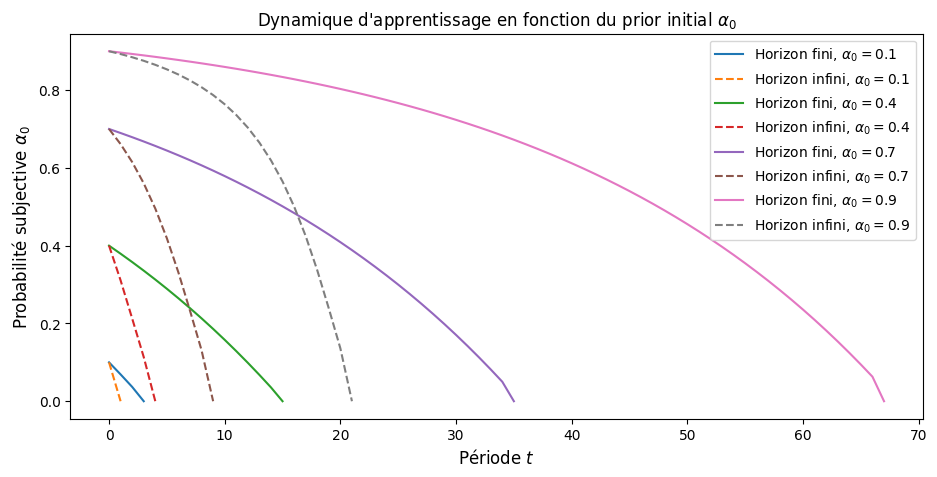

In [204]:
### plot gammas vs alphas Modifs DM
## dynamique d'apprentissage
fig, ax =plt.subplots()

for alpha0 in [0.1,0.4,0.7,0.9]:
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0) #, end=False)
    plt.plot(alphas, label=f"Horizon fini, $\\alpha_0 = {alpha0}$")
    #print(f"alpha0 = {alpha0}, one shot, {social_cost_inactive(gammas)}")

    
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0) #, end=False)
    plt.plot(alphas, label=f"Horizon infini, $\\alpha_0 = {alpha0}$",linestyle = "--")
    #print(f"alpha0 = {alpha0}, inf shot, {social_cost_inactive(gammas)}")

    #plt.plot(gammas,label=f"$\gamma, \\alpha_0 = {alpha0}$")
    #plt.plot(gammas*alphas,label=f"$p, \\alpha_0 = {alpha0}$")
    
ax.legend()
ax.set_ylabel('Probabilité subjective $\\alpha_0$', fontsize=12)
#ax.set_ylabel("Prior initial $\\alpha_0$", fontsize=12)
ax.set_xlabel('Période $t$', fontsize=12)
ax.set_title('Dynamique d\'apprentissage en fonction du prior initial $\\alpha_0$')

plt.show()

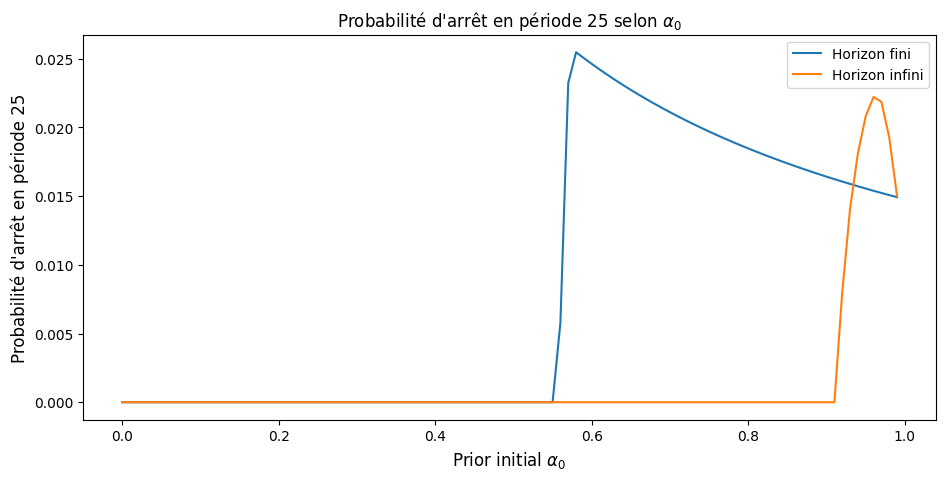

In [160]:
### plot probas date arrêt DM
proba_arret_T_one = []
proba_arret_T_inf = []

date = 25

#horizon infini

for alpha0 in np.linspace(0, 0.99, 100):
    proba_temp=1
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
    if len(gammas)<date:
        proba_temp=0
    else:
        for i in range(date-1):
            proba_temp = proba_temp*(1-gammas[i])
        proba_temp=proba_temp*gammas[date-1]
    
    proba_arret_T_inf.append(proba_temp)


#one shot

for alpha0 in np.linspace(0, 0.99, 100):
    proba_temp=1
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0)
    if len(gammas)<date:
        proba_temp=0
    else:
        for i in range(date-1):
            proba_temp = proba_temp*(1-gammas[i])
        proba_temp =proba_temp*gammas[date-1]
    
    proba_arret_T_one.append(proba_temp)

    
fig, ax = plt.subplots()
plt.plot(np.linspace(0, 0.99, 100), proba_arret_T_one, label=f"Horizon fini")
plt.plot(np.linspace(0, 0.99, 100),  proba_arret_T_inf, label=f"Horizon infini")

ax.legend()
ax.set_xlabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_title(f"Probabilité d\'arrêt en période {date} selon $\\alpha_0$", fontsize=12)
ax.set_ylabel(f"Probabilité d\'arrêt en période {date}", fontsize=12)
plt.show()

#variable explicative en ordonnée 

In [161]:
rws, alphas, gammas = simulation_inf_pol(alpha=1)

In [162]:
gammas

array([0.01774555, 0.01774555, 0.01774555, ..., 0.01774555, 0.01774555,
       1.        ])

In [163]:
cum_prod_1mgam = np.cumprod(1-gammas)
cum_prod_1mgam[:-1]

array([9.82254447e-01, 9.64823799e-01, 9.47702467e-01, 9.30884962e-01,
       9.14365894e-01, 8.98139965e-01, 8.82201975e-01, 8.66546813e-01,
       8.51169461e-01, 8.36064988e-01, 8.21228552e-01, 8.06655397e-01,
       7.92340851e-01, 7.78280325e-01, 7.64469310e-01, 7.50903379e-01,
       7.37578183e-01, 7.24489451e-01, 7.11632985e-01, 6.99004664e-01,
       6.86600440e-01, 6.74416335e-01, 6.62448444e-01, 6.50692930e-01,
       6.39146024e-01, 6.27804025e-01, 6.16663295e-01, 6.05720264e-01,
       5.94971423e-01, 5.84413326e-01, 5.74042588e-01, 5.63855885e-01,
       5.53849950e-01, 5.44021577e-01, 5.34367613e-01, 5.24884964e-01,
       5.15570590e-01, 5.06421505e-01, 4.97434775e-01, 4.88607520e-01,
       4.79936909e-01, 4.71420164e-01, 4.63054552e-01, 4.54837393e-01,
       4.46766052e-01, 4.38837941e-01, 4.31050519e-01, 4.23401289e-01,
       4.15887799e-01, 4.08507640e-01, 4.01258446e-01, 3.94137893e-01,
       3.87143698e-01, 3.80273619e-01, 3.73525454e-01, 3.66897038e-01,
      

In [164]:
len(cum_prod_1mgam)

1001

In [165]:
cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam))
cum_prod_1mgam

array([1.00000000e+00, 9.82254447e-01, 9.64823799e-01, ...,
       1.70521706e-08, 1.67495704e-08, 0.00000000e+00])

In [166]:
cum_sum_deltagamma = np.cumsum(li.delta**np.arange(len(gammas))*gammas)
cum_sum_deltagamma

array([0.01774555, 0.03531365, 0.05270607, ..., 1.77447792, 1.77447869,
       1.77452186])

In [167]:
len(cum_sum_deltagamma)

1001

In [168]:


li.delta**np.arange(len(gammas))*gammas*li.S/2
#
#

array([2.66183296e-02, 2.63521463e-02, 2.60886248e-02, ...,
       1.17247882e-06, 1.16075403e-06, 6.47568711e-05])

In [169]:


#COUT SOCIAL
def social_cost(gammas):
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam[:-1]))
    cum_sum_deltagamma = np.cumsum(li.delta**np.arange(len(gammas))*gammas)
    cum_sum_deltagamma = np.array(list(cum_sum_deltagamma))
    cum_sum_deltagamma = li.b*cum_sum_deltagamma
    s = cum_prod_1mgam*(cum_sum_deltagamma-li.delta**np.arange(len(gammas))*li.S*gammas/2)*gammas
    return np.sum(s)


def social_cost_inactive(gammas):
    term_val = li.b*(li.delta**(len(gammas))/(1-li.delta))
    return (li.b*np.sum(li.delta**(np.arange(len(gammas)))*gammas)+term_val)

In [170]:
rws, alphas, gammas = simulation_one_shot(alpha=0.8)
gammas

array([0.04166667, 0.04202899, 0.04241049, 0.04281251, 0.04323648,
       0.04368401, 0.04415682, 0.04465683, 0.04518614, 0.04574707,
       0.04634219, 0.04697434, 0.04764671, 0.04836281, 0.04912662,
       0.04994257, 0.05081569, 0.05175163, 0.05275682, 0.05383862,
       0.05500541, 0.05626688, 0.05763421, 0.05912043, 0.06074077,
       0.06251318, 0.06445894, 0.0666035 , 0.06897753, 0.07161833,
       0.07457176, 0.07789479, 0.08165911, 0.08595625, 0.09090489,
       0.09666175, 0.10343821, 0.11152636, 0.1213416 , 0.13349543,
       0.14892661, 0.1691539 , 0.19680593, 0.23686148, 0.30003216,
       0.41434915, 0.68391862, 1.        ])

In [171]:
social_cost(gammas)

-0.003737491731411805

In [172]:
social_cost_inactive(gammas)

6.575358810866978

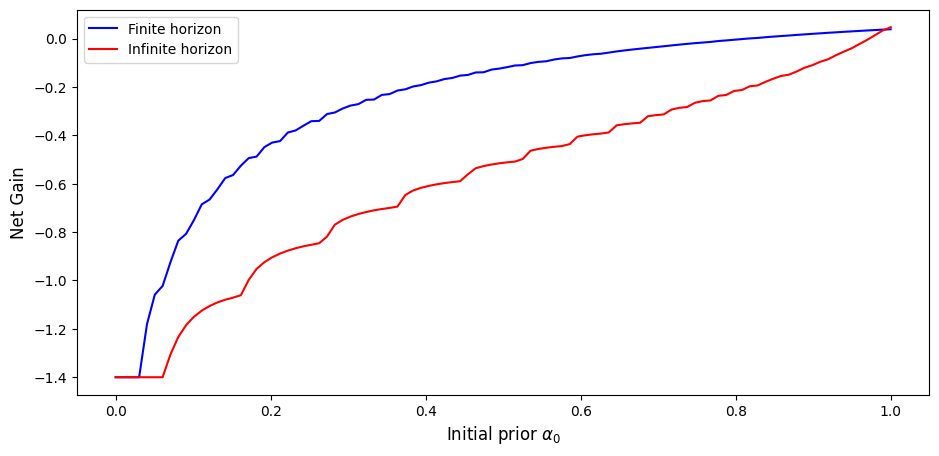

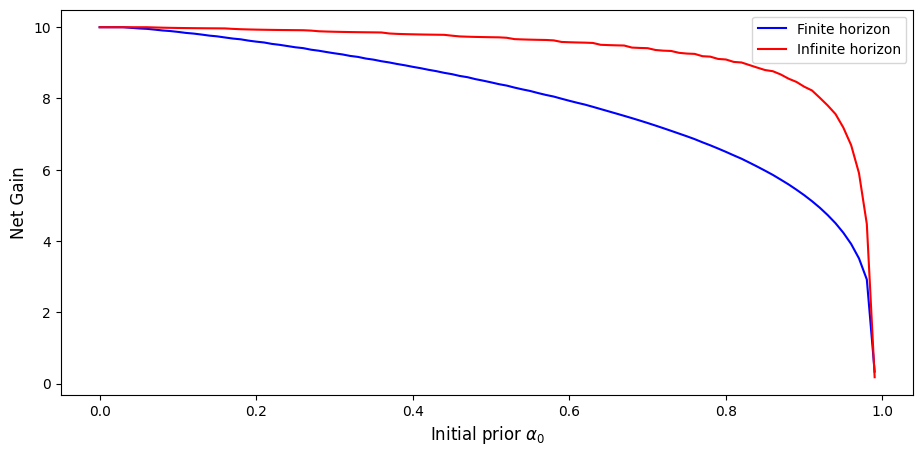

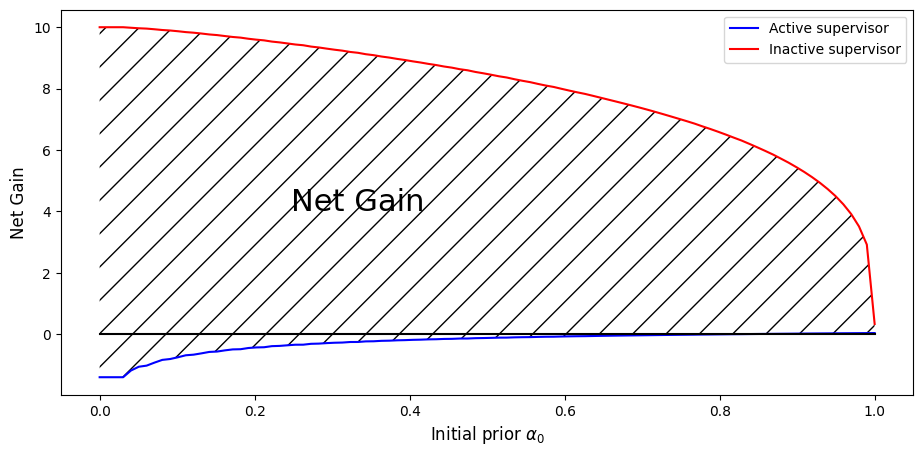

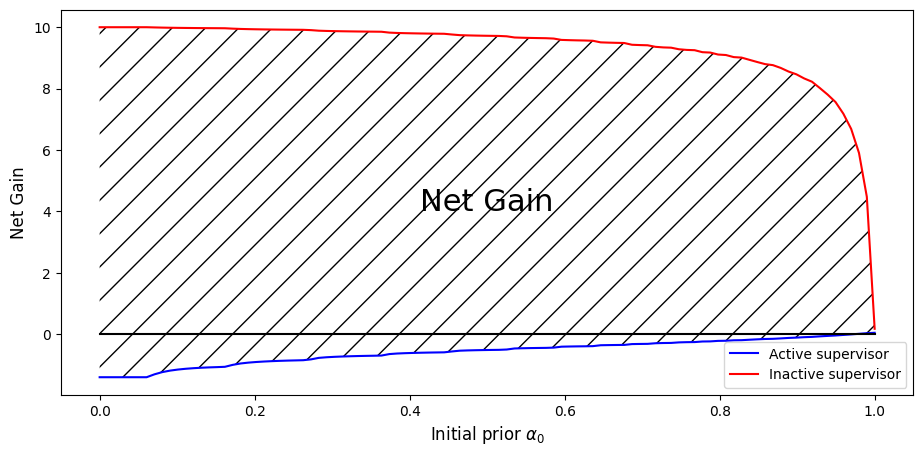

In [174]:


import matplotlib.pyplot as plt
import numpy as np

# Create lists to store social costs
social_cost_one_active = []
social_cost_one_inactive = []
social_cost_inf_active = []
social_cost_inf_inactive = []

# one shot

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0)
    social_cost_one_active.append(social_cost(gammas))
    social_cost_one_inactive.append(social_cost_inactive(gammas))

# inf policy

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
    social_cost_inf_active.append(social_cost(gammas))
    social_cost_inf_inactive.append(social_cost_inactive(gammas))

# By active/inactive

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), social_cost_one_active, label="Finite horizon", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100),  social_cost_inf_active, label="Infinite horizon", color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud when Supervisor is Active for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
plt.savefig('figure_10.png')
plt.show()

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 0.99, 100), social_cost_one_inactive, label="Finite horizon", color='blue', linestyle='-')
plt.plot(np.linspace(0, 0.99, 100),  social_cost_inf_inactive, label="Infinite horizon", color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud when Supervisor is Inactive for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
plt.savefig('figure_9.png')
plt.show()

# By inf/oneshot

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), social_cost_one_active, label="Active supervisor", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100), social_cost_one_inactive, label="Inactive supervisor", color='red', linestyle='-')
filled_poly = plt.fill_between(np.linspace(0, 1, 100), social_cost_one_active, social_cost_one_inactive,alpha=0.0001,hatch='/')
(x0, y0), (x1, y1) = filled_poly.get_paths()[0].get_extents().get_points()
ax.text((x0 + x1) / 3, (y0 + y1) / 2, "Net Gain", ha='center', va='center', fontsize=22)
plt.plot([0, 1], [0, 0], "k")

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud in Finite Horizon for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
plt.savefig('figure_2.png')
plt.show()

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100),  social_cost_inf_active, label="Active supervisor", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100),  social_cost_inf_inactive, label="Inactive supervisor", color='red', linestyle='-')
filled_poly = plt.fill_between(np.linspace(0, 1, 100), social_cost_inf_active, social_cost_inf_inactive,alpha=0.0001,hatch='/')
(x0, y0), (x1, y1) = filled_poly.get_paths()[0].get_extents().get_points()
ax.text((x0 + x1) / 2, (y0 + y1) / 2, "Net Gain", ha='center', va='center', fontsize=22)
plt.plot([0, 1], [0, 0],"k")
ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud in Infinite Horizon for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
plt.savefig('figure_5.png')

plt.show()


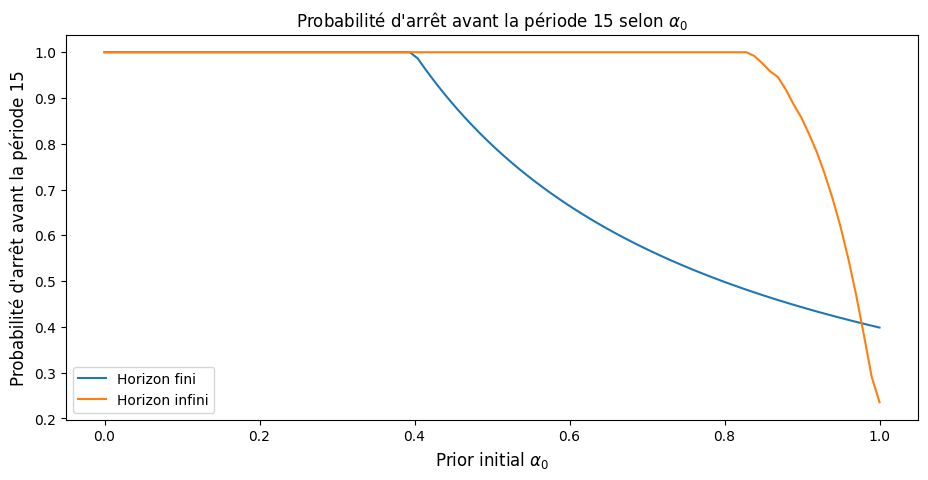

In [175]:
### plot probas date arrêt DM
proba_arret_T_one = []
proba_arret_T_inf = []

date = 15

#horizon infini

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
    
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam)[:-1])
    a = cum_prod_1mgam*gammas
    proba_cum = np.sum(a[:date])
    
    proba_arret_T_inf.append(proba_cum)


#one shot

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0)
    
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam)[:-1])
    a = cum_prod_1mgam*gammas
    proba_cum = np.sum(a[:date])
    
    proba_arret_T_one.append(proba_cum)

    
fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), proba_arret_T_one, label=f"Horizon fini")
plt.plot(np.linspace(0, 1, 100),  proba_arret_T_inf, label=f"Horizon infini")

ax.legend()
ax.set_xlabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_title(f"Probabilité d\'arrêt avant la période {date} selon $\\alpha_0$")
ax.set_ylabel(f"Probabilité d\'arrêt avant la période {date}", fontsize=12)
plt.show()

#ax.set_title(f"Probabilité d\'arrêt en T<={date} selon $\\alpha_0$")
#ax.set_ylabel(f"Probabilité d\'arrêt en T<={date}", fontsize=12)

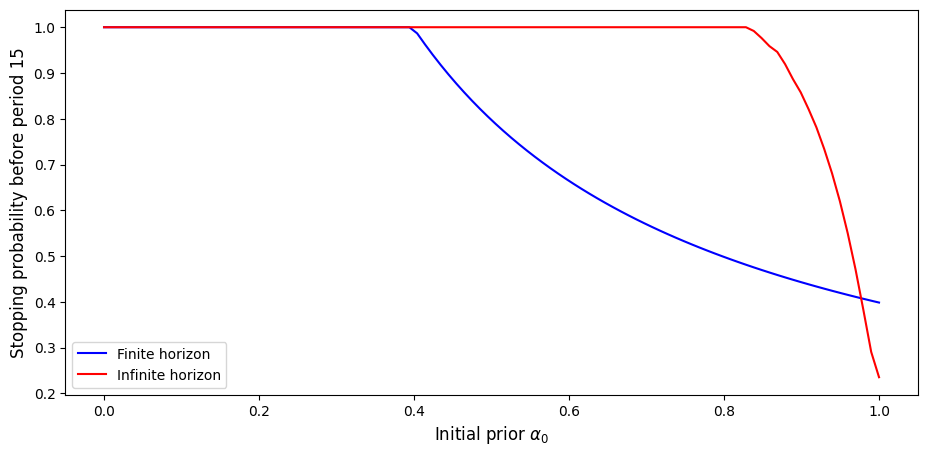

In [176]:
### Graphique des probabilités d'arrêt en date T DM
proba_arret_T_one = []
proba_arret_T_inf = []

date = 15

# Horizon infini

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
    
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam)[:-1])
    a = cum_prod_1mgam*gammas
    proba_cum = np.sum(a[:date])
    
    proba_arret_T_inf.append(proba_cum)


# One shot

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0)
    
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam)[:-1])
    a = cum_prod_1mgam*gammas
    proba_cum = np.sum(a[:date])
    
    proba_arret_T_one.append(proba_cum)

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), proba_arret_T_one, label=f"Finite horizon", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100),  proba_arret_T_inf, label=f"Infinite horizon", color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Probability of Stopping Before Period {date} According to $\\alpha_0$")
ax.set_ylabel(f"Stopping probability before period {date}", fontsize=12)
plt.savefig('figure_11.png')
plt.show()

#ax.set_title(f"Probability of Stopping in T<={date} According to $\\alpha_0$")
#ax.set_ylabel(f"Probability of Stopping in T<={date}", fontsize=12)

In [212]:
#####################
##### b = 0,01 #####
#####################

In [226]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

class Libor:

    def __init__(self,
                 delta=0.99,       # discount factor
                 b = 0.01,          # parameter of the utility
                 S = 3,
                 x_grid_min=0, 
                 x_grid_max=1,  # maximum value of the initial subjective proba
                 x_grid_size=100):

        self.delta = delta
        self.b = b
        self.S = S
        self.x_grid_size = x_grid_size

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, y, x):

        b = self.b
        S=self.S

        return b*y - (S*x*y*y)/2

    # first derivative of utility function
    def u_prime(self, y,x):

        return self.b-self.S*x*y

    def state_action_value(self, y, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        delta = self.delta
        u = self.u
        v = lambda x: np.interp(x,self.x_grid, v_array)

        return u(y,x) + delta*(1-y*x) * v(x*(1-y)/(1-x*y))



In [227]:
def T(v, Libor):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(Libor.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(Libor.state_action_value, 0, 1, (x, v))[1]

    return v_new

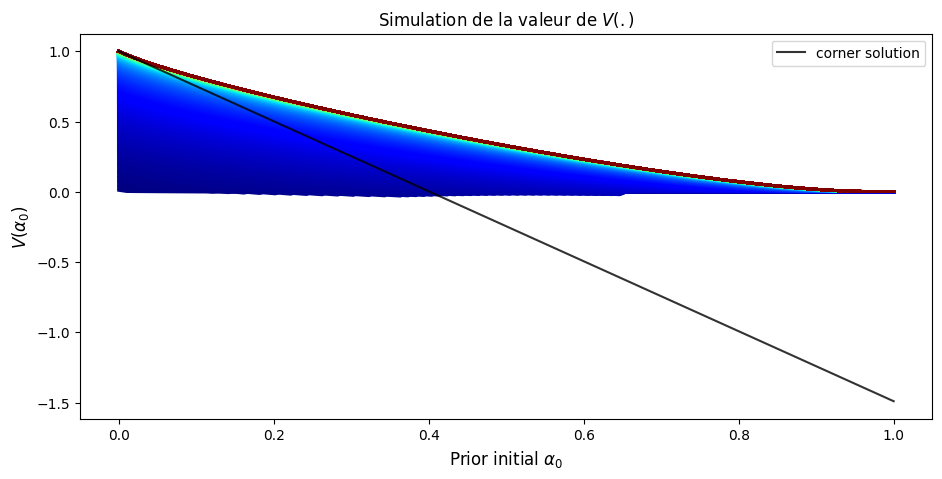

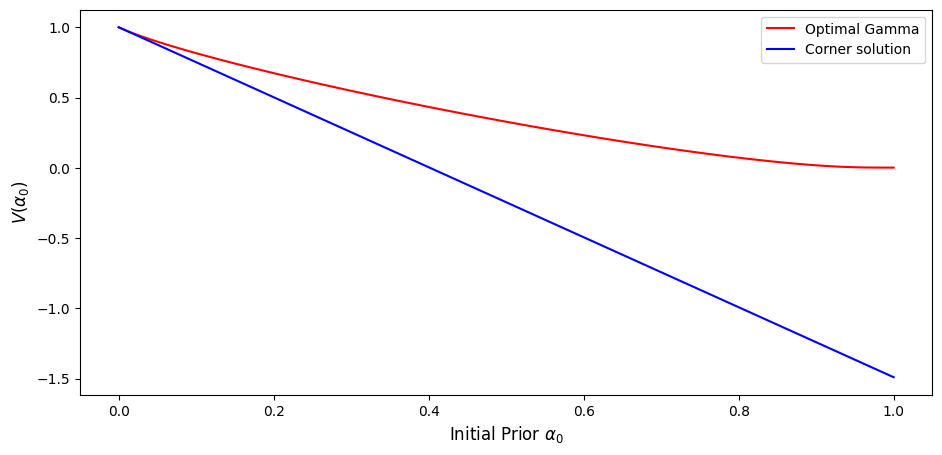

In [228]:


li = Libor()

li.x_grid_size

x_grid = li.x_grid
#v = li.u(x_grid,2) # Initial guess
v = np.empty(li.x_grid_size)*0
n = 1000 # Number of iterations

fig, ax = plt.subplots()

# ax.plot(x_grid, v, color=plt.cm.jet(0),
#       lw=2, alpha=0.8, label='Initial guess')

for i in range(n):
    v_last =v
    v = T(v, li)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=1)
    v_err=max(abs(v-v_last))

# case where the solution is corner (gamma=1)

#v_corn = li.b +li.delta*li.b/(1-li.delta)*(1-x_grid)
v_corn = li.b/(1-li.delta) -(li.S/2+li.delta*li.b/(1-li.delta))*x_grid
ax.plot(x_grid,v_corn, color='black',alpha=0.8, label='corner solution')

ax.legend()
ax.set_ylabel('$V(\\alpha_0)$', fontsize=12)
ax.set_xlabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_title('Simulation de la valeur de $V(.)$')

plt.show()



#modifs DM 
#v_func = lambda x : np.interp(x,x_grid,v)
v_func = interp1d(x_grid, v, kind='cubic',fill_value='extrapolate')

plt.figure()
plt.plot(x_grid, v_func(x_grid), label = "Optimal Gamma", color='red')  # Mettre en vert
plt.plot(x_grid,v_corn, label='Corner solution', color='blue')  # Mettre en bleu
#plt.title('Simulation of the value of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V(\\alpha_0)$", fontsize=12)

plt.legend()
plt.savefig('figure_12.png')
plt.show()


# threshold value of alpha
alpha_h = li.b/(li.S+li.delta*(li.b-0.5*li.S))
alpha_h

n_gamma=1000
alpha_range = np.linspace(alpha_h,0.999,n_gamma)
#gamma_range = np.linspace(0.01,0.99, 1000)

gammas = []
y0=alpha_h
for alpha in alpha_range:
    func_CPO = lambda y : li.u_prime((alpha-y)/(alpha*(1-y)),alpha)-li.delta*alpha*v_func(y)-li.delta*alpha*(1-y)*dv_func(y)
    #p = alpha*(1-gamma_range)/(1-alpha*gamma_range)
    sol = fsolve(func_CPO, x0= y0,xtol=1e-7)
    #gamma_approx_index = np.argmin(np.abs(res))
    #gamma_approx = gamma_range[gamma_approx_index]
    gammas.append((alpha-sol[0])/(alpha*(1-sol[0])))
    y0=alpha
    
gammas[n_gamma-1]


n_corner=50
alpha_init = np.linspace(0.001,alpha_h-0.002,n_corner)
alphavec=np.concatenate([alpha_init,alpha_range])

n_tot = n_corner+n_gamma

gammavec_6 = [1]*n_corner
gammavec_6 = gammavec_6+gammas

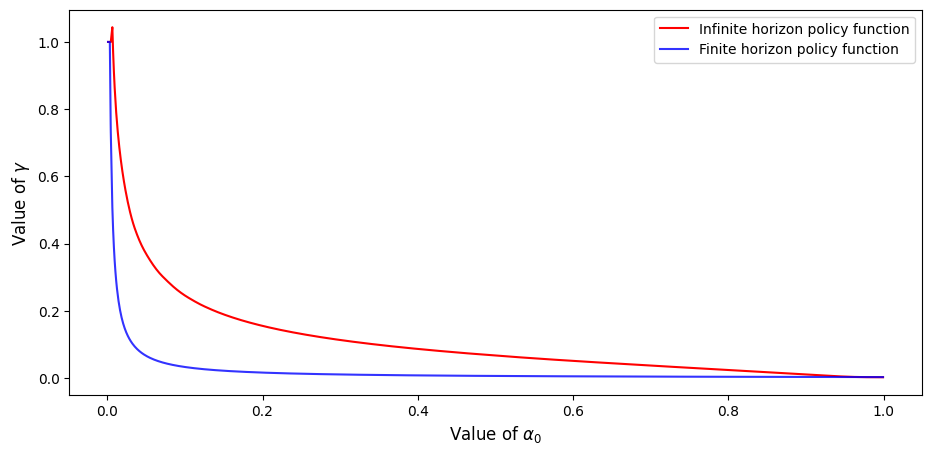

In [229]:
#policy function cas à 1 période
gamma_1per = li.b/(li.S*alphavec)

for i in range(n_tot):
    if gamma_1per[i]>1:
        gamma_1per[i]=1
        
        gammavec_6[n_tot-1]

gamma_theorique_1 = (np.sqrt((1-li.delta)**2*li.S**2+2*li.b*li.delta*(1-li.delta)*li.S)-(1-li.delta)*li.S)/(li.delta*li.S)
gamma_theorique_1

fig, ax = plt.subplots()

# Remplacez les lignes de tracé par les nouvelles
ax.plot(alphavec,gammavec_6,color='red', label='Infinite horizon policy function')  # Mettre en vert
ax.plot(alphavec,gamma_1per, color='blue', alpha=0.8, label='Finite horizon policy function')  # Mettre en bleu

ax.legend()
ax.set_xlabel('Value of $\\alpha_0$', fontsize=12)
ax.set_ylabel('Value of $\\gamma$', fontsize=12)
#ax.set_title('Comparison of Optimal Interior $\\gamma$ (policy function) for Different $\\alpha_0$ Values')
plt.savefig('figure_13.png')
plt.show()

In [182]:
##############################
########## delta 0.9 ##########
##############################

In [224]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

class Libor:

    def __init__(self,
                 delta=0.9,       # discount factor
                 b = 0.1,          # parameter of the utility
                 S = 3,
                 x_grid_min=0, 
                 x_grid_max=1,  # maximum value of the initial subjective proba
                 x_grid_size=100):

        self.delta = delta
        self.b = b
        self.S = S
        self.x_grid_size = x_grid_size

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, y, x):

        b = self.b
        S=self.S

        return b*y - (S*x*y*y)/2

    # first derivative of utility function
    def u_prime(self, y,x):

        return self.b-self.S*x*y

    def state_action_value(self, y, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        delta = self.delta
        u = self.u
        v = lambda x: np.interp(x,self.x_grid, v_array)

        return u(y,x) + delta*(1-y*x) * v(x*(1-y)/(1-x*y))


    
    

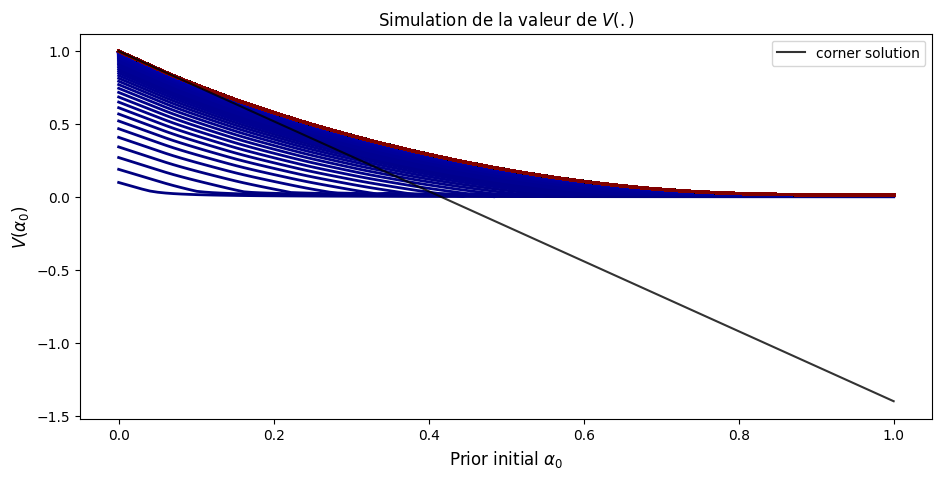

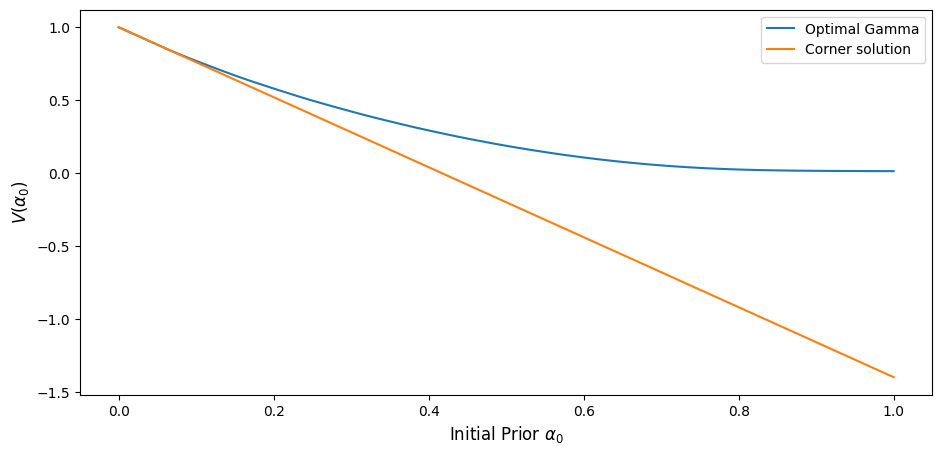

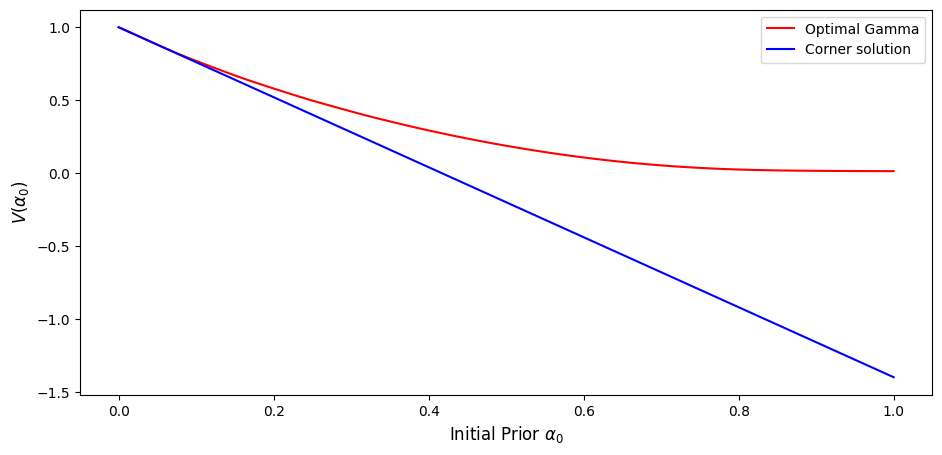

In [225]:
def T(v, Libor):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(Libor.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(Libor.state_action_value, 0, 1, (x, v))[1]

    return v_new

li = Libor()

li.x_grid_size

x_grid = li.x_grid
#v = li.u(x_grid,2) # Initial guess
v = np.empty(li.x_grid_size)*0
n = 1000 # Number of iterations

fig, ax = plt.subplots()

# ax.plot(x_grid, v, color=plt.cm.jet(0),
#       lw=2, alpha=0.8, label='Initial guess')

for i in range(n):
    v_last =v
    v = T(v, li)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=1)
    v_err=max(abs(v-v_last))

# case where the solution is corner (gamma=1)

#v_corn = li.b +li.delta*li.b/(1-li.delta)*(1-x_grid)
v_corn = li.b/(1-li.delta) -(li.S/2+li.delta*li.b/(1-li.delta))*x_grid
ax.plot(x_grid,v_corn, color='black',alpha=0.8, label='corner solution')

ax.legend()
ax.set_ylabel('$V(\\alpha_0)$', fontsize=12)
ax.set_xlabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_title('Simulation de la valeur de $V(.)$')

plt.show()


#modifs DM 
#v_func = lambda x : np.interp(x,x_grid,v)
v_func = interp1d(x_grid, v, kind='cubic',fill_value='extrapolate')

plt.figure()
plt.plot(x_grid, v_func(x_grid), label = "Optimal Gamma")
plt.plot(x_grid,v_corn, label='Corner solution')
#plt.title('Simulation of the value of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V(\\alpha_0)$", fontsize=12)

plt.legend()
#plt.savefig('figure_12bis.png')
plt.show()

#modifs DM 
#v_func = lambda x : np.interp(x,x_grid,v)
v_func = interp1d(x_grid, v, kind='cubic',fill_value='extrapolate')

plt.figure()
plt.plot(x_grid, v_func(x_grid), label = "Optimal Gamma", color='red')  # Mettre en vert
plt.plot(x_grid,v_corn, label='Corner solution', color='blue')  # Mettre en bleu
#plt.title('Simulation of the value of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V(\\alpha_0)$", fontsize=12)

plt.legend()


#plt.savefig('figure_13.png')
plt.show()


# threshold value of alpha
alpha_h = li.b/(li.S+li.delta*(li.b-0.5*li.S))
alpha_h

n_gamma=1000
alpha_range = np.linspace(alpha_h,0.999,n_gamma)
#gamma_range = np.linspace(0.01,0.99, 1000)

gammas = []
y0=alpha_h
for alpha in alpha_range:
    func_CPO = lambda y : li.u_prime((alpha-y)/(alpha*(1-y)),alpha)-li.delta*alpha*v_func(y)-li.delta*alpha*(1-y)*dv_func(y)
    #p = alpha*(1-gamma_range)/(1-alpha*gamma_range)
    sol = fsolve(func_CPO, x0= y0,xtol=1e-7)
    #gamma_approx_index = np.argmin(np.abs(res))
    #gamma_approx = gamma_range[gamma_approx_index]
    gammas.append((alpha-sol[0])/(alpha*(1-sol[0])))
    y0=alpha
    
gammas[n_gamma-1]


n_corner=50
alpha_init = np.linspace(0.001,alpha_h-0.002,n_corner)
alphavec=np.concatenate([alpha_init,alpha_range])

n_tot = n_corner+n_gamma

gammavec_6 = [1]*n_corner
gammavec_6 = gammavec_6+gammas

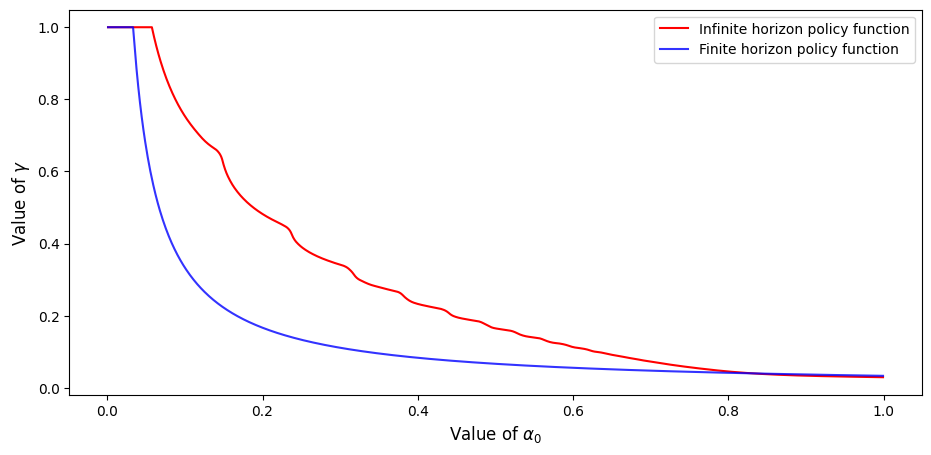

In [220]:
#policy function cas à 1 période
gamma_1per = li.b/(li.S*alphavec)

for i in range(n_tot):
    if gamma_1per[i]>1:
        gamma_1per[i]=1
        
        gammavec_6[n_tot-1]

gamma_theorique_1 = (np.sqrt((1-li.delta)**2*li.S**2+2*li.b*li.delta*(1-li.delta)*li.S)-(1-li.delta)*li.S)/(li.delta*li.S)
gamma_theorique_1


fig, ax = plt.subplots()

# Remplacez les lignes de tracé par les nouvelles
ax.plot(alphavec,gammavec_6,color='red', label='Infinite horizon policy function')  # Mettre en vert
ax.plot(alphavec,gamma_1per, color='blue', alpha=0.8, label='Finite horizon policy function')  # Mettre en bleu

ax.legend()
ax.set_xlabel('Value of $\\alpha_0$', fontsize=12)
ax.set_ylabel('Value of $\\gamma$', fontsize=12)
#ax.set_title('Comparison of Optimal Interior $\\gamma$ (policy function) for Different $\\alpha_0$ Values')
plt.savefig('figure_14.png')
plt.show()

In [186]:
##### Delta 0.95 ####

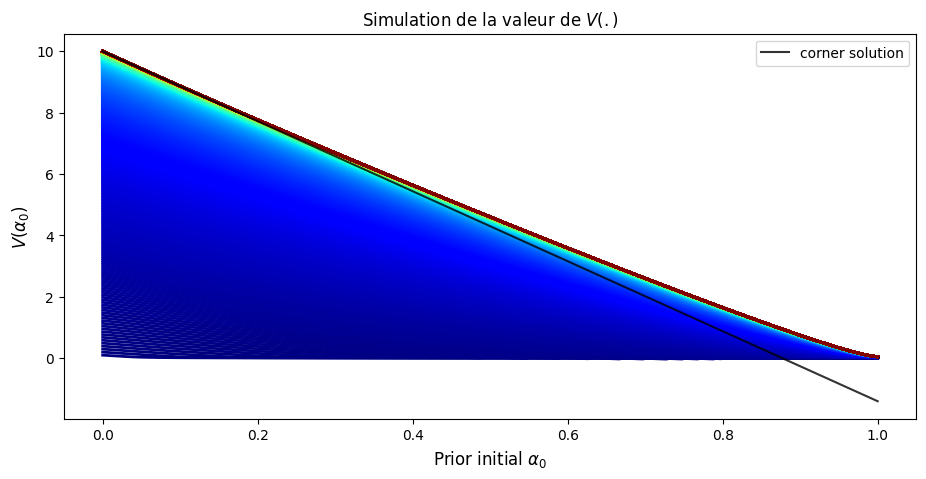

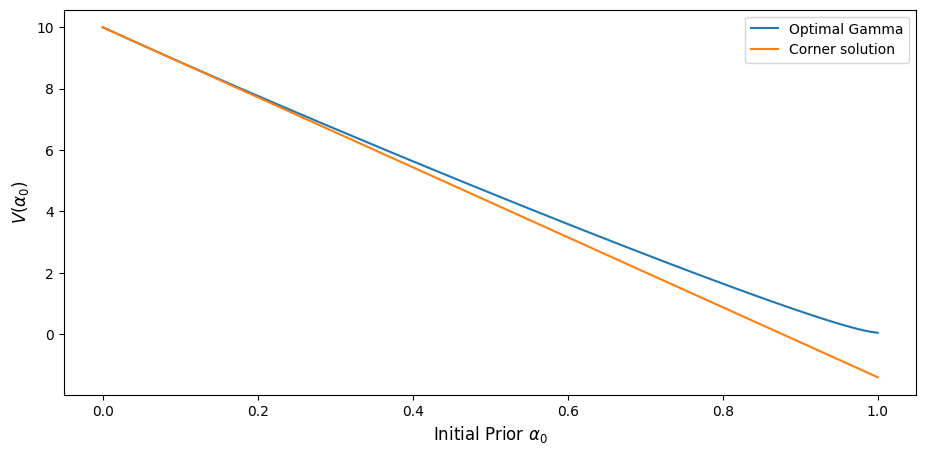

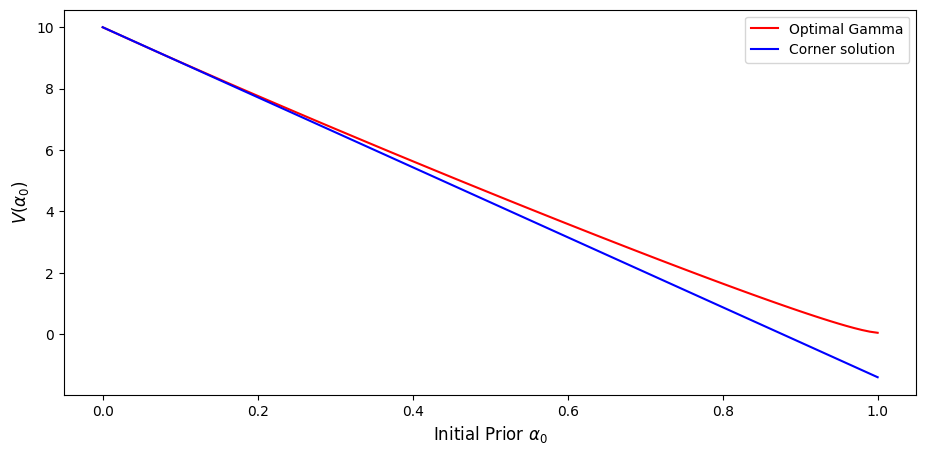

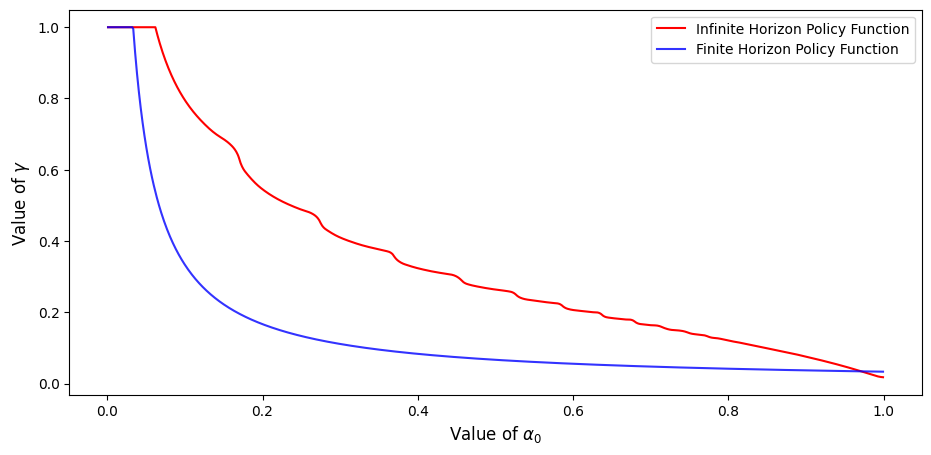

In [233]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

class Libor:

    def __init__(self,
                 delta=0.99,       # discount factor
                 b = 0.1,          # parameter of the utility
                 S = 3,
                 x_grid_min=0, 
                 x_grid_max=1,  # maximum value of the initial subjective proba
                 x_grid_size=100):

        self.delta = delta
        self.b = b
        self.S = S
        self.x_grid_size = x_grid_size

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, y, x):

        b = self.b
        S=self.S

        return b*y - (S*x*y*y)/2

    # first derivative of utility function
    def u_prime(self, y,x):

        return self.b-self.S*x*y

    def state_action_value(self, y, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        delta = self.delta
        u = self.u
        v = lambda x: np.interp(x,self.x_grid, v_array)

        return u(y,x) + delta*(1-y*x) * v(x*(1-y)/(1-x*y))





def T(v, Libor):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(Libor.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(Libor.state_action_value, 0, 1, (x, v))[1]

    return v_new

li = Libor()

li.x_grid_size

x_grid = li.x_grid
#v = li.u(x_grid,2) # Initial guess
v = np.empty(li.x_grid_size)*0
n = 1000 # Number of iterations

fig, ax = plt.subplots()

# ax.plot(x_grid, v, color=plt.cm.jet(0),
#       lw=2, alpha=0.8, label='Initial guess')

for i in range(n):
    v_last =v
    v = T(v, li)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=1)
    v_err=max(abs(v-v_last))

# case where the solution is corner (gamma=1)

#v_corn = li.b +li.delta*li.b/(1-li.delta)*(1-x_grid)
v_corn = li.b/(1-li.delta) -(li.S/2+li.delta*li.b/(1-li.delta))*x_grid
ax.plot(x_grid,v_corn, color='black',alpha=0.8, label='corner solution')

ax.legend()
ax.set_ylabel('$V(\\alpha_0)$', fontsize=12)
ax.set_xlabel('Prior initial $\\alpha_0$', fontsize=12)
ax.set_title('Simulation de la valeur de $V(.)$')

plt.show()


#modifs DM 
#v_func = lambda x : np.interp(x,x_grid,v)
v_func = interp1d(x_grid, v, kind='cubic',fill_value='extrapolate')

plt.figure()
plt.plot(x_grid, v_func(x_grid), label = "Optimal Gamma")
plt.plot(x_grid,v_corn, label='Corner solution')
#plt.title('Simulation of the value of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V(\\alpha_0)$", fontsize=12)

plt.legend()
#plt.savefig('figure_12.png')
plt.show()

#modifs DM 
#v_func = lambda x : np.interp(x,x_grid,v)
v_func = interp1d(x_grid, v, kind='cubic',fill_value='extrapolate')

plt.figure()
plt.plot(x_grid, v_func(x_grid), label = "Optimal Gamma", color='red')  # Mettre en vert
plt.plot(x_grid,v_corn, label='Corner solution', color='blue')  # Mettre en bleu
#plt.title('Simulation of the value of $V(.)$')
plt.xlabel("Initial Prior $\\alpha_0$", fontsize=12)
plt.ylabel("$V(\\alpha_0)$", fontsize=12)

plt.legend()
#plt.savefig('figure_13.png')
plt.show()


# threshold value of alpha
alpha_h = li.b/(li.S+li.delta*(li.b-0.5*li.S))
alpha_h

n_gamma=1000
alpha_range = np.linspace(alpha_h,0.999,n_gamma)
#gamma_range = np.linspace(0.01,0.99, 1000)

gammas = []
y0=alpha_h
for alpha in alpha_range:
    func_CPO = lambda y : li.u_prime((alpha-y)/(alpha*(1-y)),alpha)-li.delta*alpha*v_func(y)-li.delta*alpha*(1-y)*dv_func(y)
    #p = alpha*(1-gamma_range)/(1-alpha*gamma_range)
    sol = fsolve(func_CPO, x0= y0,xtol=1e-7)
    #gamma_approx_index = np.argmin(np.abs(res))
    #gamma_approx = gamma_range[gamma_approx_index]
    gammas.append((alpha-sol[0])/(alpha*(1-sol[0])))
    y0=alpha
    
gammas[n_gamma-1]


n_corner=50
alpha_init = np.linspace(0.001,alpha_h-0.002,n_corner)
alphavec=np.concatenate([alpha_init,alpha_range])

n_tot = n_corner+n_gamma

gammavec_6 = [1]*n_corner
gammavec_6 = gammavec_6+gammas



#policy function cas à 1 période
gamma_1per = li.b/(li.S*alphavec)

for i in range(n_tot):
    if gamma_1per[i]>1:
        gamma_1per[i]=1
        
        gammavec_6[n_tot-1]

gamma_theorique_1 = (np.sqrt((1-li.delta)**2*li.S**2+2*li.b*li.delta*(1-li.delta)*li.S)-(1-li.delta)*li.S)/(li.delta*li.S)
gamma_theorique_1


fig, ax = plt.subplots()

# Remplacez les lignes de tracé par les nouvelles
ax.plot(alphavec,gammavec_6,color='red', label='Infinite Horizon Policy Function')  # Mettre en vert
ax.plot(alphavec,gamma_1per, color='blue', alpha=0.8, label='Finite Horizon Policy Function')  # Mettre en bleu

ax.legend()
ax.set_xlabel('Value of $\\alpha_0$', fontsize=12)
ax.set_ylabel('Value of $\\gamma$', fontsize=12)
#ax.set_title('Comparison of Optimal Interior $\\gamma$ (policy function) for Different $\\alpha_0$ Values')
#plt.savefig('figure_13.png')
plt.show()

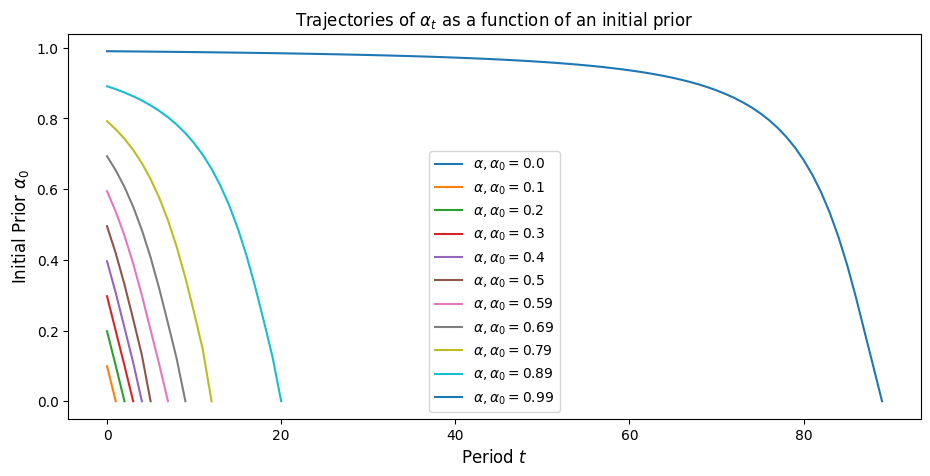

In [234]:
# simul inf pol modifs DM
Tmax = 1000
def simulation_inf_pol(alpha):
#, end=True):
    #done = False
    cum_reward = 0
    list_rewards = []
    list_alphas = []
    list_gammas = []

    t = 0
    while (alpha>alpha_h) and (t<Tmax):
        gamma = policy(alpha)
        # print(f"t= {t}, alpha = {alpha}, gamma = {gamma}")

        #u = np.random.uniform()  if end else 2
        #if u < gamma*alpha:
        #   done = True
        #else:
        cum_reward += li.b*gamma
        list_rewards.append(cum_reward)
        list_alphas.append(alpha)
        list_gammas.append(gamma)
        
        alpha = alpha * (1-gamma)/(1-alpha*gamma)
        t += 1
    list_rewards = np.array(list_rewards)
    list_alphas = np.array(list_alphas+[0])
    list_gammas = np.array(list_gammas+[1])
    return list_rewards, list_alphas, list_gammas


plt.figure()

for alpha0 in np.linspace(0, 0.99, 11):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0) 
    # end=False)
    plt.plot(alphas, label=f"$\\alpha, \\alpha_0 = {round(alpha0,2)}$")
    plt.title('Trajectories of $\\alpha_t$ as a function of an initial prior')
    plt.xlabel("Period $t$", fontsize=12)
    plt.ylabel("Initial Prior $\\alpha_0$", fontsize=12)

plt.legend()
plt.show()

average_has_stopped = []
horizon = 100
for alpha0 in np.linspace(0, 1, 30):
    has_stopped = []
    for _ in range(100):
        rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
        has_stopped.append(len(rws) < horizon)
    
    average_has_stopped.append(np.mean(np.array(has_stopped)))





# Simulation one shot modifs DM

def simulation_one_shot(alpha, T=22):#,end = True):
    #done = False  #
    cum_reward = 0
    list_rewards = []
    list_alphas = []
    list_gammas = []

    t = 0
    while (alpha>li.b/li.S) and (t<Tmax):
        if alpha>0:
            gamma =min(1,li.b/(li.S*alpha))
        else:
            gamma=1
            
        cum_reward += li.b*gamma
        list_rewards.append(cum_reward)
        list_alphas.append(alpha)
        list_gammas.append(gamma)
        alpha = alpha * (1-gamma)/(1-alpha*gamma)

        t += 1
    list_rewards = np.array(list_rewards)
    list_alphas = np.array(list_alphas+[0])
    list_gammas = np.array(list_gammas+[1])
    return list_rewards, list_alphas, list_gammas

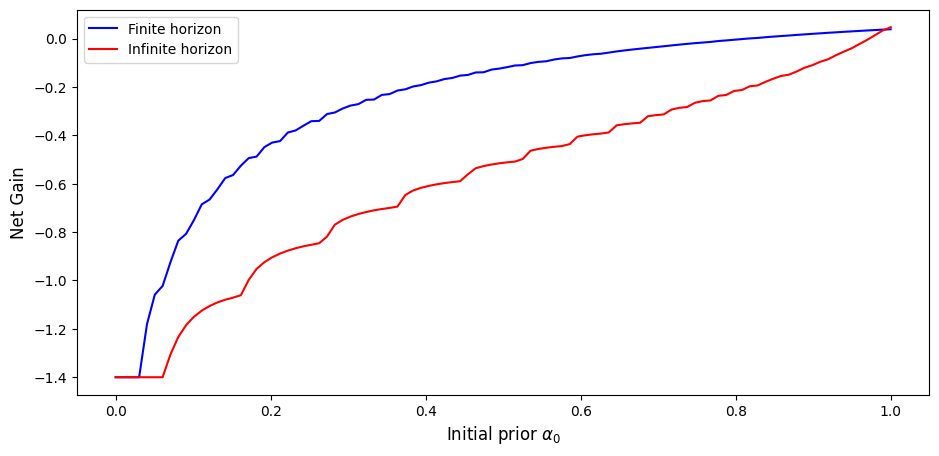

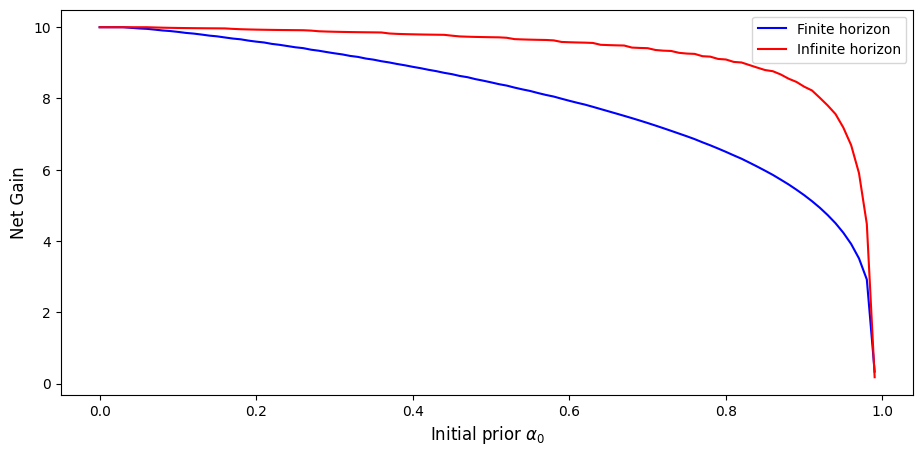

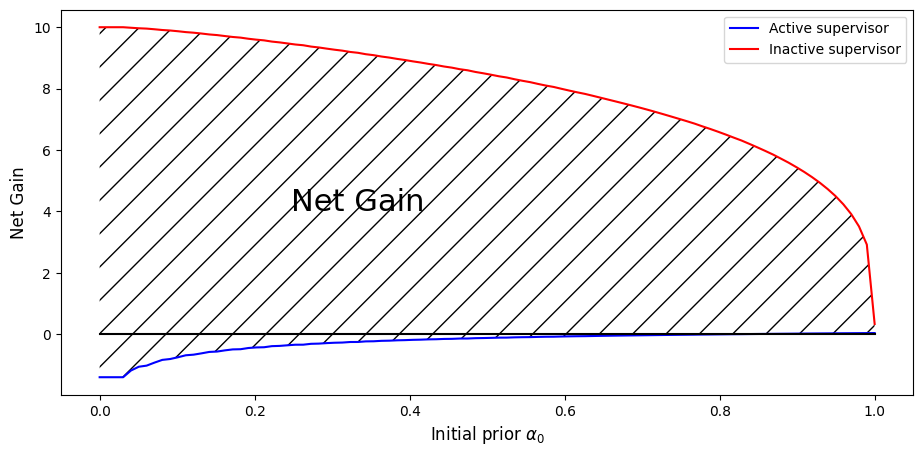

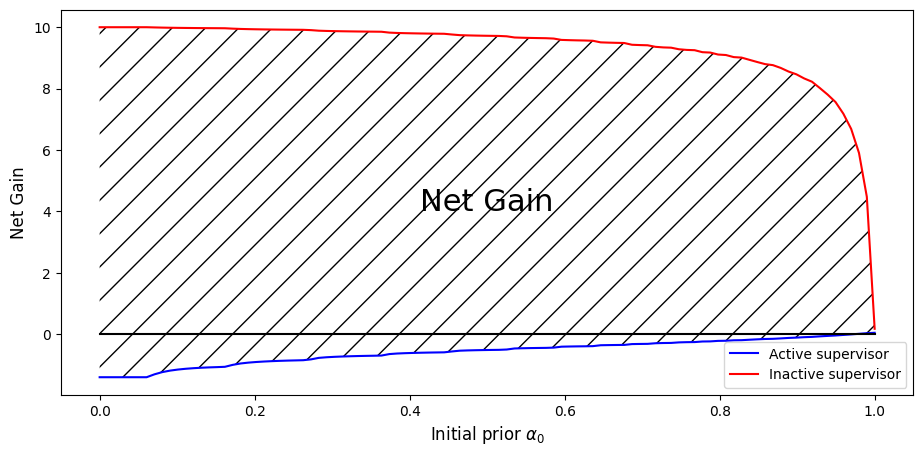

In [235]:
rws, alphas, gammas = simulation_inf_pol(alpha=1)
cum_prod_1mgam = np.cumprod(1-gammas)
cum_prod_1mgam[:-1]

cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam))
cum_prod_1mgam

cum_sum_deltagamma = np.cumsum(li.delta**np.arange(len(gammas))*gammas)
cum_sum_deltagamma

len(cum_sum_deltagamma)

li.delta**np.arange(len(gammas))*gammas*li.S/2
#
#

#COUT SOCIAL
def social_cost(gammas):
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam[:-1]))
    cum_sum_deltagamma = np.cumsum(li.delta**np.arange(len(gammas))*gammas)
    cum_sum_deltagamma = np.array(list(cum_sum_deltagamma))
    cum_sum_deltagamma = li.b*cum_sum_deltagamma
    s = cum_prod_1mgam*(cum_sum_deltagamma-li.delta**np.arange(len(gammas))*li.S*gammas/2)*gammas
    return np.sum(s)


def social_cost_inactive(gammas):
    term_val = li.b*(li.delta**(len(gammas))/(1-li.delta))
    return (li.b*np.sum(li.delta**(np.arange(len(gammas)))*gammas)+term_val)

rws, alphas, gammas = simulation_one_shot(alpha=0.8)
gammas


import matplotlib.pyplot as plt
import numpy as np

# Create lists to store social costs
social_cost_one_active = []
social_cost_one_inactive = []
social_cost_inf_active = []
social_cost_inf_inactive = []

# one shot

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0)
    social_cost_one_active.append(social_cost(gammas))
    social_cost_one_inactive.append(social_cost_inactive(gammas))

# inf policy

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
    social_cost_inf_active.append(social_cost(gammas))
    social_cost_inf_inactive.append(social_cost_inactive(gammas))

# By active/inactive

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), social_cost_one_active, label="Finite horizon", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100),  social_cost_inf_active, label="Infinite horizon", color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud when Supervisor is Active for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
#plt.savefig('figure_10.png')
plt.show()

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 0.99, 100), social_cost_one_inactive, label="Finite horizon", color='blue', linestyle='-')
plt.plot(np.linspace(0, 0.99, 100),  social_cost_inf_inactive, label="Infinite horizon", color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud when Supervisor is Inactive for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
#plt.savefig('figure_9.png')
plt.show()

# By inf/oneshot

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), social_cost_one_active, label="Active supervisor", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100), social_cost_one_inactive, label="Inactive supervisor", color='red', linestyle='-')
filled_poly = plt.fill_between(np.linspace(0, 1, 100), social_cost_one_active, social_cost_one_inactive,alpha=0.0001,hatch='/')
(x0, y0), (x1, y1) = filled_poly.get_paths()[0].get_extents().get_points()
ax.text((x0 + x1) / 3, (y0 + y1) / 2, "Net Gain", ha='center', va='center', fontsize=22)
plt.plot([0, 1], [0, 0], "k")

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud in Finite Horizon for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
plt.savefig('figure_15.png')
plt.show()

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100),  social_cost_inf_active, label="Active supervisor", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100),  social_cost_inf_inactive, label="Inactive supervisor", color='red', linestyle='-')
filled_poly = plt.fill_between(np.linspace(0, 1, 100), social_cost_inf_active, social_cost_inf_inactive,alpha=0.0001,hatch='/')
(x0, y0), (x1, y1) = filled_poly.get_paths()[0].get_extents().get_points()
ax.text((x0 + x1) / 2, (y0 + y1) / 2, "Net Gain", ha='center', va='center', fontsize=22)
plt.plot([0, 1], [0, 0],"k")
ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Net Gain Generated by Fraud in Infinite Horizon for $\\alpha_0$")
ax.set_ylabel('Net Gain', fontsize=12)
plt.savefig('figure_16.png')

plt.show()


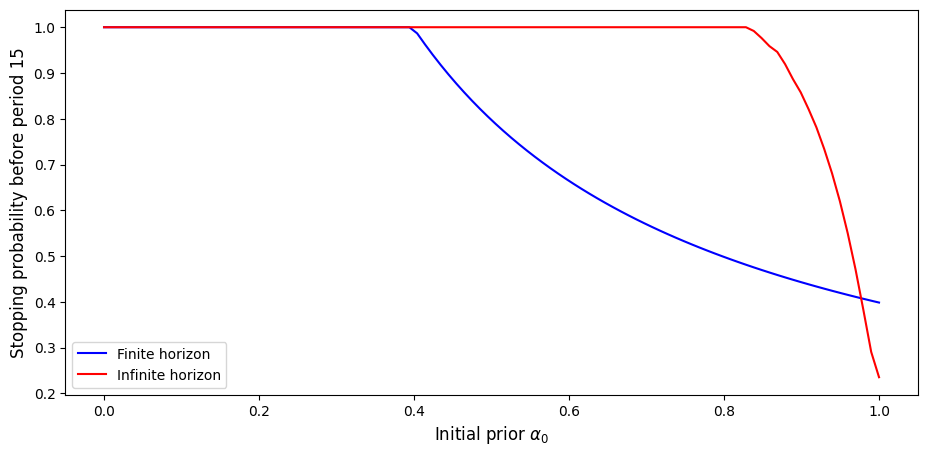

In [236]:
### Graphique des probabilités d'arrêt en date T DM
proba_arret_T_one = []
proba_arret_T_inf = []

date = 15

# Horizon infini

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_inf_pol(alpha=alpha0)
    
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam)[:-1])
    a = cum_prod_1mgam*gammas
    proba_cum = np.sum(a[:date])
    
    proba_arret_T_inf.append(proba_cum)


# One shot

for alpha0 in np.linspace(0, 1, 100):
    rws, alphas, gammas = simulation_one_shot(alpha=alpha0)
    
    cum_prod_1mgam = np.cumprod(1-gammas)
    cum_prod_1mgam = np.array([1]+list(cum_prod_1mgam)[:-1])
    a = cum_prod_1mgam*gammas
    proba_cum = np.sum(a[:date])
    
    proba_arret_T_one.append(proba_cum)

fig, ax = plt.subplots()
plt.plot(np.linspace(0, 1, 100), proba_arret_T_one, label=f"Finite horizon", color='blue', linestyle='-')
plt.plot(np.linspace(0, 1, 100),  proba_arret_T_inf, label=f"Infinite horizon", color='red', linestyle='-')

ax.legend()
ax.set_xlabel('Initial prior $\\alpha_0$', fontsize=12)
#ax.set_title(f"Probability of Stopping Before Period {date} According to $\\alpha_0$")
ax.set_ylabel(f"Stopping probability before period {date}", fontsize=12)
plt.savefig('figure_17.png')
plt.show()

#ax.set_title(f"Probability of Stopping in T<={date} According to $\\alpha_0$")
#ax.set_ylabel(f"Probability of Stopping in T<={date}", fontsize=12)
